# Analysis of ArXiv Papers
- By: Arnav Jaiswal

## Aim
The aim of this notebook is to analyze and compare research papers from the ArXiv repository for the periods 2019-2020 and 2023-2024.

## Overview
This notebook performs the following tasks:
1. **Data Collection**: Fetches research papers from ArXiv based on specified categories and time periods.
2. **Data Visualization**: Visualizes the distribution of categories and the number of papers published over time.
3. **Text Processing**: Applies stemming, lemmatization, and phrase extraction to clean the abstracts.
4. **Clustering**: Uses KMeans clustering to group similar papers and visualizes the clusters.
5. **Topic Modeling**: Performs LDA topic modeling to identify key topics in the research papers.
6. **Comparison**: Compares the topics between the two time periods to identify trends and changes in research focus.

### Data Collection

The data was collected using the `arxiv` Python library, which allows for querying and retrieving metadata of research papers from the arXiv repository through its API. The collection process involved fetching papers based on their submission dates and categories, ensuring a representative sample for each month within the specified periods.

### Data Structure

The dataset is stored in two separate CSV files, `arxiv_papers.csv` for the 2023-2024 period and `arxiv_papers2.csv` for the 2019-2020 period. Each file contains the following columns:

- `title` (str): The title of the research paper.
- `abstract` (str): A brief summary of the research paper.
- `category` (str): The primary category of the research paper.
- `published` (datetime): The publication date of the research paper.
- `year_month` (Period): The year and month extracted from the publication date.

### Data Summary

#### 2019-2020 Dataset (`df_2020`)

- **Number of Entries**: 4793 (50 papers per category per month for 24 months (4 categories * 50 papers * 24 months = 4800 papers)) - 7 (not enough papers in that month)
- **Categories**: cs.AI, cs.CL, cs.CV, cs.LG
- **Date Range**: January 2019 to December 2020


#### 2023-2024 Dataset (`df_2023`)

- **Number of Entries**: 4800 (50 papers per category per month for 24 months (4 categories * 50 papers * 24 months = 4800 papers))
- **Categories**: cs.AI, cs.CL, cs.CV, cs.LG
- **Date Range**: January 2023 to December 2024

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_2023= pd.read_csv('arxiv_papers.csv')
df_2020 = pd.read_csv('arxiv_papers2.csv')


In [2]:
# Display the first few rows of the DataFrame
df_2023.head()

,title,abstract,category,published
0,Approximate inference of marginals using the I...,Exact inference of marginals in probabilistic ...,cs.AI,01-06-2023
1,Probabilistic Adaptation of Text-to-Video Models,Large text-to-video models trained on internet...,cs.AI,02-06-2023
2,PDT: Pretrained Dual Transformers for Time-awa...,Pre-training on large models is prevalent and ...,cs.AI,02-06-2023
3,Generative Adversarial Networks for Data Augme...,One way to expand the available dataset for tr...,cs.AI,03-06-2023
4,Painsight: An Extendable Opinion Mining Framew...,As the e-commerce market continues to expand a...,cs.AI,03-06-2023


In [3]:
df_2020.head()

,title,abstract,category,published
0,Discovering Implicational Knowledge in Wikidata,Knowledge graphs have recently become the stat...,cs.AI,03-02-2019
1,Neural-Network Guided Expression Transformation,"Optimizing compilers, as well as other transla...",cs.AI,06-02-2019
2,Re-determinizing Information Set Monte Carlo T...,This technical report documents the winner of ...,cs.AI,16-02-2019
3,Solving Nurse Scheduling Problem Using Constra...,Staff scheduling is a universal problem that c...,cs.AI,04-02-2019
4,Can Meta-Interpretive Learning outperform Deep...,World-class human players have been outperform...,cs.AI,26-02-2019


In [4]:
# Summary statistics for df
print("\nSummary statistics:")
df_2023.describe()


Summary statistics:


,title,abstract,category,published
count,4800,4800,4800,4800
unique,4800,4800,4,328
top,Approximate inference of marginals using the I...,Exact inference of marginals in probabilistic ...,cs.AI,01-07-2024
freq,1,1,1200,97


In [5]:
print("\nSummary statistics for df2:")
df_2020.describe()


Summary statistics for df2:


,title,abstract,category,published
count,4793,4793,4793,4793
unique,4793,4793,4,657
top,Discovering Implicational Knowledge in Wikidata,Knowledge graphs have recently become the stat...,cs.LG,06-10-2020
freq,1,1,1200,36



Missing values in df_2023:
title        0
abstract     0
category     0
published    0
dtype: int64

Missing values in df_2020:
title        0
abstract     0
category     0
published    0
dtype: int64


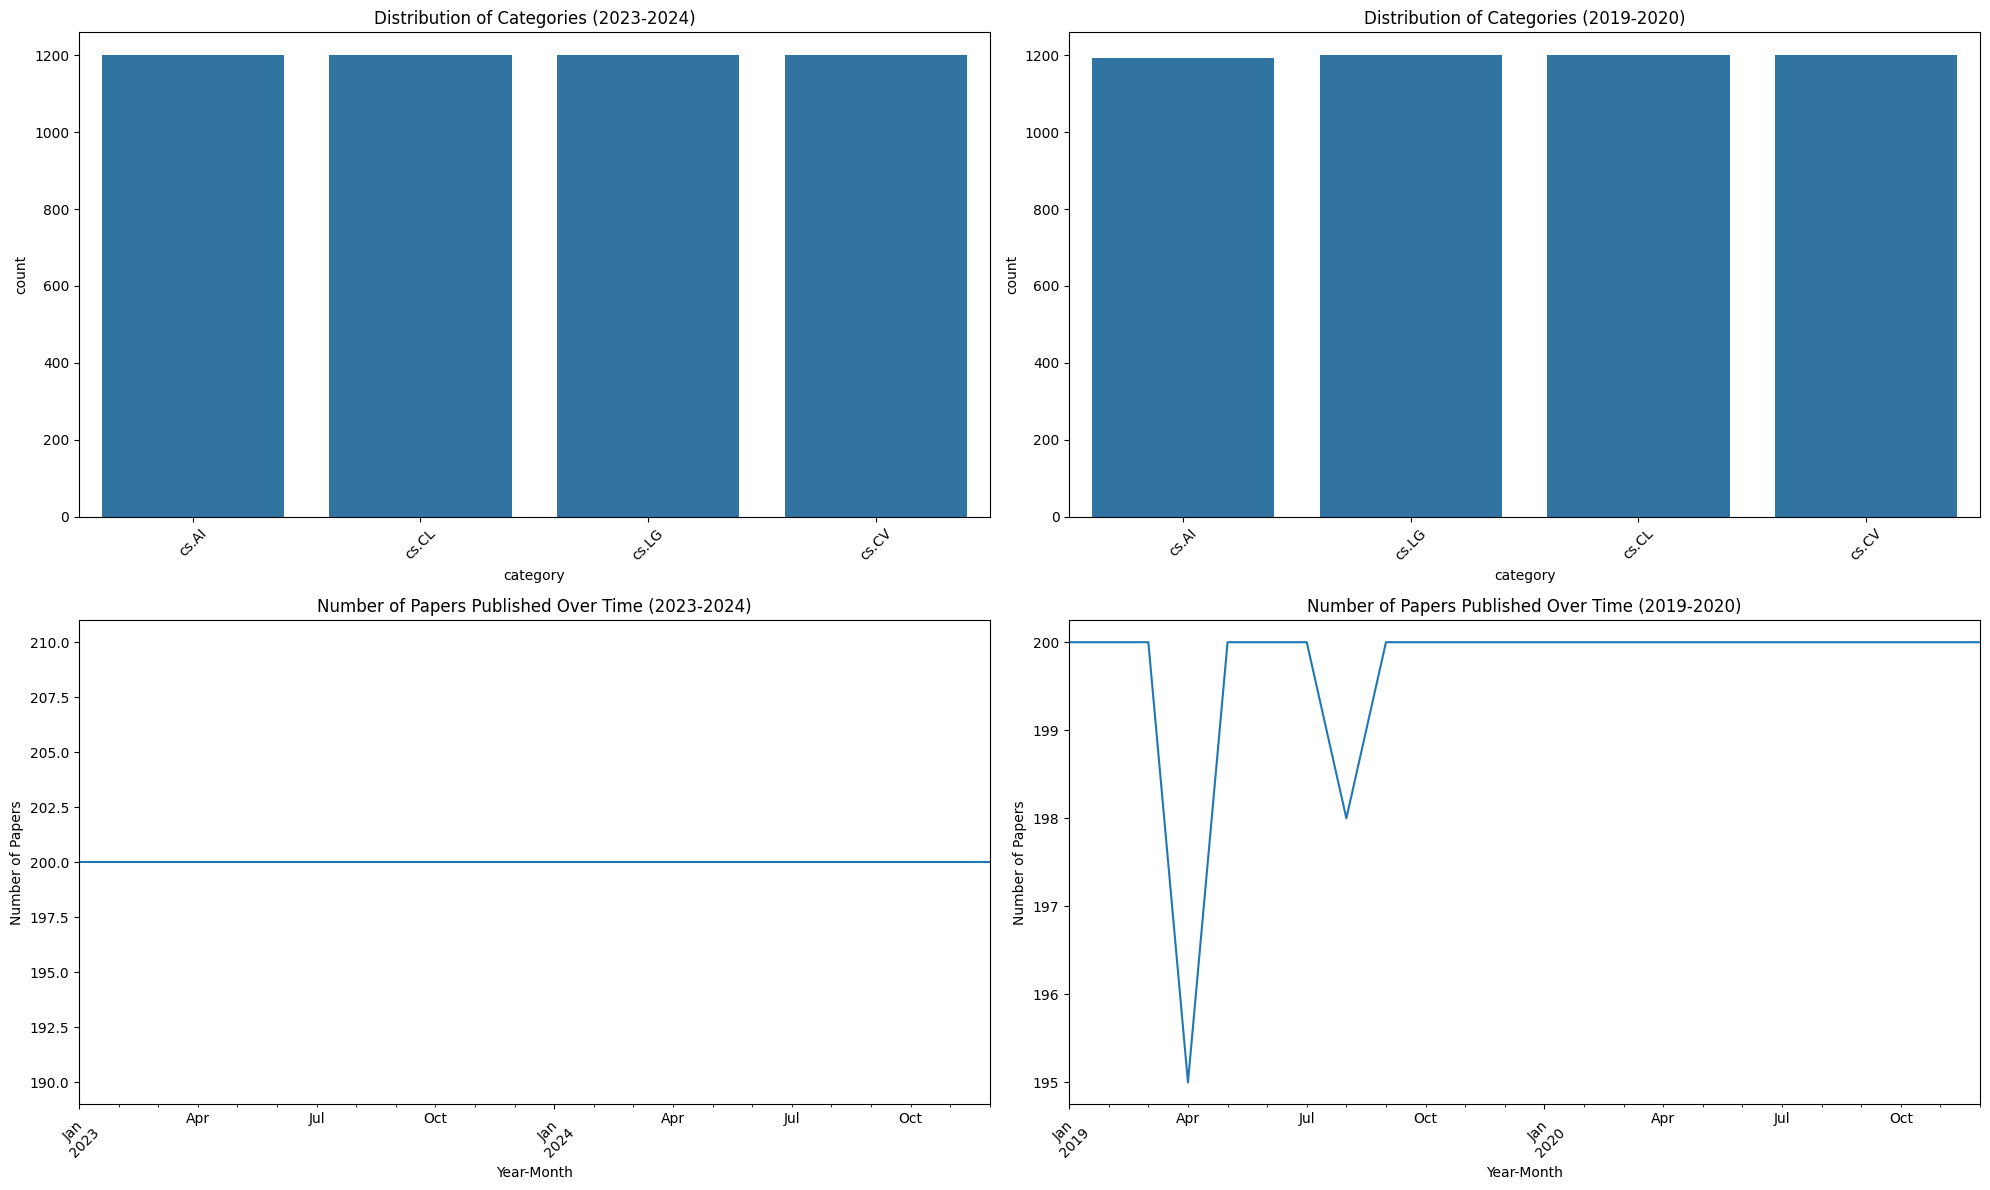

In [6]:
# Check for missing values
print("\nMissing values in df_2023:")
print(df_2023.isnull().sum())

print("\nMissing values in df_2020:")
print(df_2020.isnull().sum())

# Create a figure with four subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Visualize the distribution of categories for df_2023
sns.countplot(data=df_2023, x='category', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Categories (2023-2024)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Visualize the distribution of categories for df_2020
sns.countplot(data=df_2020, x='category', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Categories (2019-2020)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Convert 'published' column to datetime format and extract year and month for df_2023
try:
    df_2023['published'] = pd.to_datetime(df_2023['published'], format='%d-%m-%Y')
    df_2023['year_month'] = df_2023['published'].dt.to_period('M')
    time_trend_2023 = df_2023['year_month'].value_counts().sort_index()
    time_trend_2023.plot(kind='line', ax=axes[1, 0])
    axes[1, 0].set_title('Number of Papers Published Over Time (2023-2024)')
    axes[1, 0].set_xlabel('Year-Month')
    axes[1, 0].set_ylabel('Number of Papers')
    axes[1, 0].tick_params(axis='x', rotation=45)
except KeyError:
    print("\n'published' column not found in df_2023. Skipping time-based trend analysis.")
except ValueError:
    print("\nCould not convert 'published' column to datetime in df_2023. Check the date format.")

# Convert 'published' column to datetime format and extract year and month for df_2020
try:
    df_2020['published'] = pd.to_datetime(df_2020['published'], format='%d-%m-%Y')
    df_2020['year_month'] = df_2020['published'].dt.to_period('M')
    time_trend_2020 = df_2020['year_month'].value_counts().sort_index()
    time_trend_2020.plot(kind='line', ax=axes[1, 1])
    axes[1, 1].set_title('Number of Papers Published Over Time (2019-2020)')
    axes[1, 1].set_xlabel('Year-Month')
    axes[1, 1].set_ylabel('Number of Papers')
    axes[1, 1].tick_params(axis='x', rotation=45)
except KeyError:
    print("\n'published' column not found in df_2020. Skipping time-based trend analysis.")
except ValueError:
    print("\nCould not convert 'published' column to datetime in df_2020. Check the date format.")

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### Data Visualization

The dataset has been visualized to show the distribution of categories and the number of papers published over time for both periods. The visualizations include:

- **Distribution of Categories**: Bar plots showing the count of papers in each category for both periods.
- **Number of Papers Published Over Time**: Line plots showing the trend of paper publications over the months for both periods.

Papers for the year 2019-2020 have slightly less papers in two of the months but it is a very insignificant amount, so it can be ignored

In [7]:
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import re
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to stem and lemmatize text
def stem_and_lemmatize(text):
    words = text.split()
    stemmed = [stemmer.stem(word) for word in words]
    lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]
    return ' '.join(lemmatized)

# Function to process a single dataframe
def process_dataframe(df):
    # Show examples before and after stemming and lemmatizing
    print(f"\nExamples Before and After Stemming and Lemmatizing for {df['published'].min().year}:\n")
    for i in range(min(7, len(df))):
        original = df.iloc[i]['abstract']
        cleaned = stem_and_lemmatize(original)
        print(f"Original Abstract {i+1}:\t{original[:200]}...")  # Show first 200 characters
        print(f"Cleaned Abstract {i+1}:\t{cleaned[:200]}...")  # Show first 200 characters

    with tqdm_joblib(tqdm(desc="Stemming and Lemmatizing", total=len(df), leave=True, position=0)) as progress_bar:
        df.loc[:, 'cleaned_abstract'] = Parallel(n_jobs=-1)(
            delayed(stem_and_lemmatize)(text) for text in df['abstract']
        )
    return df

df_2020_processed = process_dataframe(df_2020)
df_2023_processed = process_dataframe(df_2023)

c:\Users\arnav\anaconda3\envs\FAI_Project\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



Examples Before and After Stemming and Lemmatizing for 2019:

Original Abstract 1:	Knowledge graphs have recently become the state-of-the-art tool for representing the diverse and complex knowledge of the world. Examples include the proprietary knowledge graphs of companies such as ...
Cleaned Abstract 1:	knowledg graph have recent becom the state-of-the-art tool for repres the diver and complex knowledg of the world. exampl includ the proprietari knowledg graph of compani such a google, facebook, ibm,...
Original Abstract 2:	Optimizing compilers, as well as other translator systems, often work by rewriting expressions according to equivalence preserving rules. Given an input expression and its optimized form, finding the ...
Cleaned Abstract 2:	optim compilers, a well a other translat systems, often work by rewrit express accord to equival preserv rules. given an input express and it optim form, find the sequenc of rule that were appli is a ...
Original Abstract 3:	This technical rep

Stemming and Lemmatizing:   0%|          | 0/4793 [00:00<?, ?it/s]

  0%|          | 0/4793 [00:00<?, ?it/s]


Examples Before and After Stemming and Lemmatizing for 2023:

Original Abstract 1:	Exact inference of marginals in probabilistic graphical models (PGM) is known to be intractable, necessitating the use of approximate methods. Most of the existing variational techniques perform itera...
Cleaned Abstract 1:	exact infer of margin in probabilist graphic model (pgm) is known to be intractable, necessit the use of approxim methods. most of the exist variat techniqu perform iter messag pas in loopi graph whic...
Original Abstract 2:	Large text-to-video models trained on internet-scale data have demonstrated exceptional capabilities in generating high-fidelity videos from arbitrary textual descriptions. However, adapting these mod...
Cleaned Abstract 2:	larg text-to-video model train on internet-scal data have demonstr except capabl in gener high-fidel video from arbitrari textual descriptions. however, adapt these model to task with limit domain-spe...
Original Abstract 3:	Pre-training on la

Stemming and Lemmatizing:   0%|          | 0/4800 [00:00<?, ?it/s]

  0%|          | 0/4800 [00:00<?, ?it/s]

### Stemming and Lemmatization Process

Stemming and lemmatization are text normalization techniques used in natural language processing (NLP) to reduce words to their base or root form. This helps in reducing the dimensionality of the text data and improving the performance of NLP models. 

#### Stemming
Stemming is the process of reducing a word to its base or root form by removing suffixes. The resulting stem may not be a valid word in the language. For example:
- "running" -> "run"
- "jumps" -> "jump"
- "easily" -> "easili"

In the code, the `PorterStemmer` from the `nltk` library is used for stemming:
```python
stemmer = PorterStemmer()
stemmed = [stemmer.stem(word) for word in words]
```

#### Lemmatization
Lemmatization is the process of reducing a word to its base or dictionary form, known as the lemma. Unlike stemming, lemmatization considers the context and converts the word to a meaningful base form. For example:
- "running" -> "run"
- "better" -> "good"
- "geese" -> "goose"

In the code, the `WordNetLemmatizer` from the `nltk` library is used for lemmatization:
```python
lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]
```

This process helps in standardizing the abstract, making it easier to analyze and model.

## Result Analysis

The printing has been done to be make comparison easier. The effects of stemming and lemmatization are eveident as a lot of words have changed their forms reducing complexity and noise in the data.

In [8]:
from gensim.models.phrases import Phrases, Phraser
import gensim.corpora as corpora
from nltk.corpus import stopwords
from joblib import Parallel, delayed
from tqdm import tqdm
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


# Function to clean text
def clean_text(text, stop_words):
    text = re.sub(r'[^\w\s]', '', str(text), re.UNICODE)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words and len(word) > 2])
    return text

# Function to apply Phraser model
def apply_phraser(sentences, phraser):
    return phraser[sentences]

def extract_phrases(sentences, forced_phrases):

    # First bigram pass
    bigram_1 = Phrases(sentences, min_count=5, threshold=100)
    bigram_mod_1 = Phraser(bigram_1)

    # Apply the first bigram model
    sentences = [bigram_mod_1[sentence] for sentence in sentences]

    # Force specific words to form bigrams in the first pass
    for phrase in forced_phrases:
        bigram_1.add_vocab([phrase.split()])

    # Second bigram pass
    bigram_2 = Phrases(sentences, min_count=5, threshold=100)
    bigram_mod_2 = Phraser(bigram_2)

    # Apply the second bigram model
    sentences = [bigram_mod_2[sentence] for sentence in sentences]

    return sentences

# Function to update stop words with low TF-Idf_2023terms
def update_stop_words_with_low_tfidf(df, stop_words):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.98, min_df=2, stop_words=stop_words.copy(), max_features=5000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_abstract'])
    terms = tfidf_vectorizer.get_feature_names_out()
    term_sums = tfidf_matrix.sum(axis=0).A1
    tfidf_threshold = 10
    low_tfidf_terms = [terms[i] for i in range(len(terms)) if term_sums[i] < tfidf_threshold]
    stop_words.extend(low_tfidf_terms)
    return stop_words

# Function to process DataFrame
def process_dataframe(df):
    # Define stop words
    stop_words = stopwords.words('english')
    custom_stop_words = ['this', 'our', 'propose', 'show', 'paper', 'study', 'new', 'method', 'also', 'use', 'based', 'result', 'data', 'using', 'approach', 'algorithm', 'algorithms', 'technique', 'techniques', 'system', 'systems','method', 'methods', 'methodology', 'approach', 'methodologies', 'framework', 'frameworks', 'application', 'applications', 'analyze', 'demonstrate', 'evaluate', 'investigate', 'propose','proposed','novel','however', 'develop', 'implement', 'design', 'assess', 'compare', 'examine', 'explore', 'identify', 'measure','performance','problem','problems', 'optimize', 'simulate', 'validate', 'results', 'findings', 'conclude', 'conclusion', 'research', 'researches', 'researcher', 'researchers', 'investigator', 'investigators', 'scientist', 'scientists','experiments','experiment','experimentations','experimenter','experimenters','experimenting', 'reseach','existing' ]
    
    stop_words.extend(custom_stop_words)

    # Initial text cleaning
    df.loc[:, 'cleaned_abstract'] = df['abstract'].apply(lambda x: clean_text(x, stop_words))

    # Phrase extraction using Gensim
    sentences = [abstract.split() for abstract in df['cleaned_abstract']]
    forced_phrases = ['learning', 'model', 'models']
    sentences = extract_phrases(sentences, forced_phrases)

    # Apply the Phraser model to sentences
    df.loc[:, 'cleaned_abstract'] = [' '.join(sentence) for sentence in sentences]

    stop_words.extend(forced_phrases)

    # Update stop words with low TF-IDF terms
    stop_words = update_stop_words_with_low_tfidf(df, stop_words)
    print(f"Final stop words: {stop_words[-100:]}")
    # Final text cleaning
    df.loc[:, 'cleaned_abstract'] = df['cleaned_abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words and len(word) > 2]))

    return df,stop_words


### Text Processing Pipeline

The text processing pipeline involves several steps to clean, normalize, and prepare the text data for further analysis. Each step is crucial for improving the quality and relevance of the text data, which ultimately enhances the performance of downstream tasks such as clustering and topic modeling.

#### **1. Stop Words Removal**
Stop words are common words (such as "the", "is", "in") that occur frequently in the text but do not carry significant meaning. Removing these words helps in reducing the dimensionality of the text data and improving the performance of text analysis algorithms. Custom stop words specific to the domain (e.g., "method", "result") are also added to the list to further reduce noise.

#### **2. Phrase Extraction**
Phrase extraction involves identifying common phrases (bigrams and trigrams) in the text data using techniques like the Gensim Phrases model. This step helps in capturing multi-word expressions (e.g., "machine learning", "neural network", "deep learning model") that carry significant meaning and are treated as single tokens in subsequent analysis. The double bigram model is used to form better trigrams, ensuring that important multi-word expressions are accurately captured.

#### **3. TF-IDF Vectorization**
TF-IDF (Term Frequency-Inverse Document Frequency) vectorization converts the text data into numerical features by calculating the importance of words in the corpus. The term frequency (TF) measures how frequently a word appears in a document, while the inverse document frequency (IDF) measures how important a word is by considering its occurrence across all documents. This step helps in identifying the most relevant terms in the text data. Additionally, low TF-IDF terms are identified and added to the stop words list to further reduce noise in the text data.


> **Phrase Extraction vs. N-gram Range in Vectorizer**
When deciding between phrase extraction and using an n-gram range in the vectorizer, I opted for phrase extraction for several reasons:
> - **Phrase Extraction**: By using models like Gensim's Phrases, I can identify and extract common phrases (bigrams and trigrams) from the text data. This method helps in capturing meaningful multi-word expressions that frequently occur together, such as "machine learning" or "neural network". These phrases are then treated as single tokens in subsequent analysis, which significantly improves the quality of the text data.
> - **N-gram Range in Vectorizer**: While setting the n-gram range in the vectorizer (e.g., `ngram_range=(1, 3)`) allows the vectorizer to consider unigrams, bigrams, and trigrams during the text vectorization process, it may also include less meaningful combinations of words that do not occur frequently together. This can lead to increased dimensionality and noise in the text data.

> __By choosing phrase extraction, I ensure that only meaningful and frequent multi-word expressions are captured, reducing noise and improving the relevance of the text data for analysis. This approach aligns better with my goal of enhancing the performance of downstream tasks such as clustering and topic modeling.__

#### **4. Final Text Cleaning**
After updating the stop words list with low TF-IDF terms, the text data is cleaned again to remove these terms. This step ensures that only the most relevant words are retained in the text data, further reducing noise and improving the quality of the text data for analysis.

### **Justification of Steps**

1. **Stop Words Removal**: Eliminates common words that do not add significant meaning, reducing noise in the text data.
2. **Phrase Extraction**: Captures multi-word expressions that carry significant meaning, improving the quality of the text data.
3. **TF-IDF Vectorization**: Identifies the most relevant terms in the text data, enhancing the performance of downstream tasks.
4. **Final Text Cleaning**: Ensures that only the most relevant words are retained, improving the quality and relevance of the text data for analysis.


In [9]:
df_2020_processed,_ = process_dataframe(df_2020)
df_2023_processed,stop_words = process_dataframe(df_2023)
# Display some examples
print("\nExamples from df_2020:")
for i in range(min(10, len(df_2020_processed))):
    print(f"Cleaned Abstract {i+1}: {df_2020_processed['cleaned_abstract'].iloc(0)[i]}")

print("\nExamples from df_2023:")
for i in range(min(10, len(df_2023_processed))):
    print(f"Cleaned Abstract {i+1}: {df_2023_processed['cleaned_abstract'].iloc(0)[i]}")


Final stop words: ['vqa', 'vulnerability', 'vulnerable', 'vulnerable_adversarial', 'want', 'warping', 'wasserstein', 'wasserstein_distance', 'water', 'ways', 'weak', 'weak_supervision', 'weaker', 'weakly', 'weakly_supervised', 'weaklysupervised', 'weaknesses', 'wearable', 'weather', 'web', 'web_services', 'website', 'weight', 'weighting', 'welfare', 'well_suited', 'welldefined', 'wellestablished', 'wellknown', 'wellstudied', 'whenever', 'whereas', 'whereby', 'wherein', 'whilst', 'white', 'whole', 'whose', 'wide', 'wide_range', 'wide_variety', 'widely', 'widely_adopted', 'widely_applied', 'widely_studied', 'widelyused', 'wider', 'widespread', 'width', 'wikidata', 'wikipedia', 'wild', 'wildfire', 'wildlife', 'win', 'window', 'windows', 'winning', 'wireless', 'wise', 'without_losing', 'without_requiring', 'witnessed', 'wmi', 'wmt', 'word_embedding', 'wordlevel', 'wordnet', 'wordvec', 'worked', 'workers', 'workflow', 'workflows', 'working', 'workload', 'workshop', 'worlds', 'worldwide', 'w

## Result Analysis

In the cleaned abstracts printed, it can be seen that a no stop words occur anymore and bigrams have also formed with '_'. Eg. artificial_intelligence which is a very common bigram for my choice of dataset.

In [10]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pandas as pd

# Function to perform clustering
def vectorize_and_reduce_dimensionality(df, stop_words, n_components=700):
    try:
        # Re-vectorize (with final stop words)
        vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=stop_words, max_features=2000)
        X = vectorizer.fit_transform(df['cleaned_abstract'])
        # Embedding (using Truncated SVD for dimensionality reduction)
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_matrix = svd.fit_transform(X)
        svd_matrix = Normalizer().fit_transform(svd_matrix)
        print(f"Explained Variance Retained: {svd.explained_variance_ratio_.sum() * 100:.2f}%")
        return svd_matrix
    except Exception as e:
        print(f"Error during vectorization and dimensionality reduction: {e}")
        return None

def perform_vectorization_and_reduction_concurrently(df_2020_processed, df_2023_processed, stop_words, n_components=700):
    with ThreadPoolExecutor() as executor:
        future_2020 = executor.submit(vectorize_and_reduce_dimensionality, df_2020_processed, stop_words, n_components)
        future_2023 = executor.submit(vectorize_and_reduce_dimensionality, df_2023_processed, stop_words, n_components)

        with tqdm(total=2, desc="Vectorization and Dimensionality Reduction", leave=True, position=0) as pbar:
            svd_matrix_2020 = future_2020.result()
            pbar.update(1)
            svd_matrix_2023 = future_2023.result()
            pbar.update(1)

    return svd_matrix_2020, svd_matrix_2023

# Example Usage (assuming df_2020_processed, df_2023_processed, stop_words are already defined)
svd_matrix_2020, svd_matrix_2023 = perform_vectorization_and_reduction_concurrently(df_2020_processed, df_2023_processed, stop_words)

if svd_matrix_2020 is not None and svd_matrix_2023 is not None:
    print("Vectorization and dimensionality reduction completed successfully for both years.")
else:
    print("Vectorization and dimensionality reduction failed for at least one year.")


Vectorization and Dimensionality Reduction:  50%|█████     | 1/2 [01:23<01:23, 83.18s/it]

Explained Variance Retained: 94.71%


Vectorization and Dimensionality Reduction: 100%|██████████| 2/2 [01:23<00:00, 41.88s/it]

Explained Variance Retained: 91.52%
Vectorization and dimensionality reduction completed successfully for both years.


The two datasets (`df_2020_processed` and `df_2023_processed`) are vectorized and then go through dimensionality reduction for clustering.

1. **Text Vectorization**:
    - The `CountVectorizer` from `sklearn.feature_extraction.text` is used to convert the text data into a matrix of token counts. This step transforms the cleaned abstracts into numerical features that can be used for clustering.
    - The `ngram_range=(1, 3)` parameter ensures that unigrams, bigrams, and trigrams are considered, capturing more context from the text.
    - The `stop_words` parameter is used to remove common words that do not contribute to the clustering process, reducing noise in the data.
    - The `max_features=2000` parameter limits the number of features to the top 2000 most frequent terms, which helps in managing the computational complexity.

2. **Dimensionality Reduction**:
    - The `TruncatedSVD` from `sklearn.decomposition` is used to reduce the dimensionality of the vectorized text data. This step helps in capturing the most important features while reducing the number of dimensions, making the clustering process more efficient.
    - The `n_components=700` parameter specifies the number of dimensions to retain after the reduction. This value is chosen to balance between retaining enough information and reducing computational load.
    - The `Normalizer` is applied to the SVD-transformed matrix to scale the features, ensuring that each feature contributes equally to the clustering process.

3. **Clustering Function**:
    - The `perform_clustering` function encapsulates the vectorization and dimensionality reduction steps. It returns the SVD-transformed matrix, which is ready for clustering.
    - The `perform_clustering_concurrently` function manages the concurrent execution of the clustering process for both datasets. It submits the clustering tasks to the executor and waits for their completion.


By combining these steps, the code efficiently prepares the text data for clustering, reduces its dimensionality, and performs the clustering process concurrently for two datasets. This approach helps in handling large text datasets and speeds up the overall execution time.

## Result Analysis
After dimensionality reduction, the explained variance is 90%+ for both the datasets which is very reasonable as it implies most of the important information is still retained

Calculating metrics: 100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


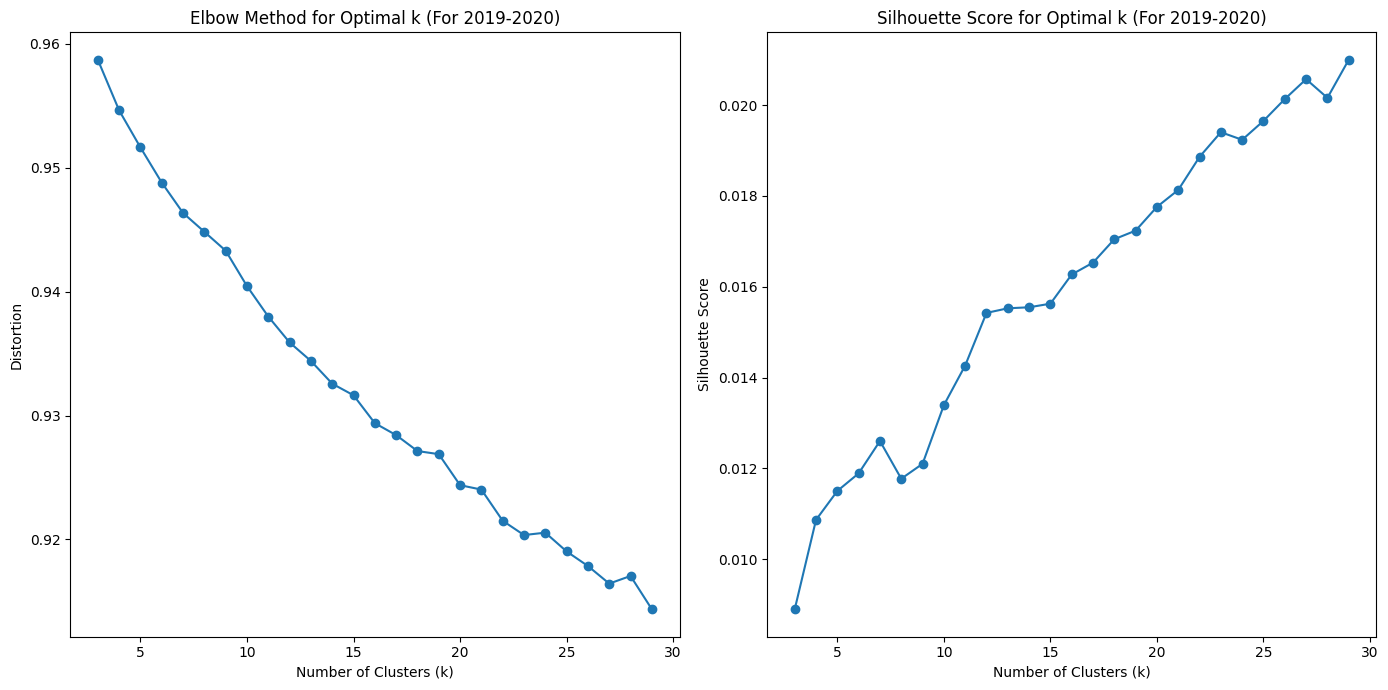

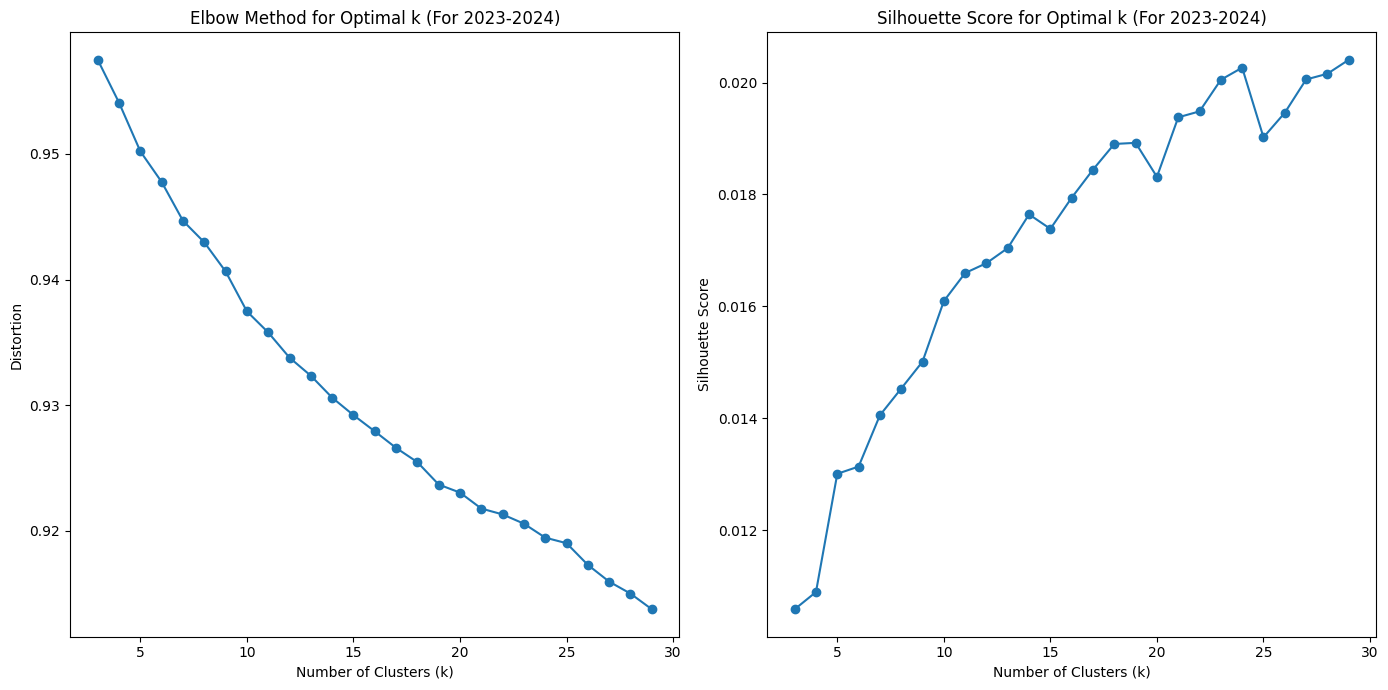

In [11]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def calculate_kmeans_metrics(svd_matrix, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(svd_matrix)
    distortion = sum(np.min(cdist(svd_matrix, kmeans.cluster_centers_, 'euclidean'), axis=1)) / svd_matrix.shape[0]
    silhouette = silhouette_score(svd_matrix, kmeans.labels_)
    return k, distortion, silhouette

def calculate_metrics_concurrently(svd_matrix, k_values):
    distortion_dict = {}
    silhouette_dict = {}
    
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(calculate_kmeans_metrics, svd_matrix, k): k for k in k_values}
        
        with tqdm(total=len(k_values), desc="Calculating metrics", leave=True, position=0) as pbar:
            for future in futures:
                k, distortion, silhouette = future.result()
                distortion_dict[k] = distortion
                silhouette_dict[k] = silhouette
                pbar.update(1)
    
    return distortion_dict, silhouette_dict

def plot_metrics(k_values, distortion_dict, silhouette_dict, title_suffix):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Plot distortion
    axes[0].plot(k_values, [distortion_dict[k] for k in k_values], marker='o')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Distortion')
    axes[0].set_title(f'Elbow Method for Optimal k ({title_suffix})')

    # Plot silhouette score
    axes[1].plot(k_values, [silhouette_dict[k] for k in k_values], marker='o')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title(f'Silhouette Score for Optimal k ({title_suffix})')

    plt.tight_layout()
    plt.show()

# Define k values
k_values = range(3, 30)

# Calculate metrics concurrently for both datasets
distortion_2020, silhouette_2020 = calculate_metrics_concurrently(svd_matrix_2020, k_values)
distortion_2023, silhouette_2023 = calculate_metrics_concurrently(svd_matrix_2023, k_values)

# Plot the metrics
plot_metrics(k_values, distortion_2020, silhouette_2020, 'For 2019-2020')
plot_metrics(k_values, distortion_2023, silhouette_2023, 'For 2023-2024')


### Experiment with Different Values of k for KMeans Clustering

This code performs an experiment to determine the optimal number of clusters (k) for KMeans clustering using two metrics: distortion and silhouette score.

**Function `calculate_distortion_and_silhouette`**:
- Takes an SVD matrix and a range of k values.
- For each k, it fits a KMeans model and calculates:
    - **Distortion**: Average distance from each point to its assigned cluster center.
    - **Silhouette Score**: Measures how similar a point is to its own cluster compared to other clusters.
- Returns lists of distortion and silhouette scores for each k.

This experiment helps in selecting the optimal number of clusters for KMeans clustering by balancing between compactness (distortion) and separation (silhouette score).

## Result Analysis
From the graphs, it can be seen that more clusters = better distortion and silhouette scores. There is no clear formation of an 'elbow' to decide an optional choice of k. This is due to extensive size of the dataset and its nature which includes a lot of jargon words which are hypercontextualised and cannot form meaningful clusters 

In [12]:
from concurrent.futures import as_completed, ThreadPoolExecutor
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer

def perform_clustering(df, svd_matrix, n_clusters=5):
    """
    Perform KMeans clustering and visualize results using Plotly.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        svd_matrix (np.ndarray): SVD matrix for the data.
        n_clusters (int): Number of clusters for KMeans.

    Returns:
        pd.DataFrame: DataFrame with an additional 'cluster' column.
        dict: Dictionary containing top words for each cluster.
        plotly.graph_objects.Figure: Interactive 3D plot.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    df.loc[:, 'cluster'] = kmeans.fit_predict(svd_matrix)

    # Store top words per cluster
    top_words_dict = {}
    for cluster_id in range(n_clusters):
        cluster_text = df[df['cluster'] == cluster_id]['cleaned_abstract']
        if cluster_text.empty:
            top_words_dict[cluster_id] = ["No documents"]
            continue
        tfidf_vectorizer = TfidfVectorizer(max_features=5000)
        tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_text)
        try:
            top_words_idx = tfidf_matrix.sum(axis=0).argsort()[0, ::-1].tolist()[0]
            top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_words_idx]
        except IndexError:
            top_words = ["No significant terms"]
        top_words_dict[cluster_id] = top_words
    
    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=3,perplexity=500, random_state=42)
    tsne_matrix = tsne.fit_transform(svd_matrix)

    # Create an interactive 3D scatter plot using Plotly
    fig = go.Figure()

    for cluster_id in range(n_clusters):
        cluster_points = tsne_matrix[df['cluster'] == cluster_id]
        fig.add_trace(go.Scatter3d(
            x=cluster_points[:, 0],
            y=cluster_points[:, 1],
            z=cluster_points[:, 2],
            mode='markers',
            marker=dict(size=3, opacity=0.7),
            name=f'Cluster {cluster_id}'
        ))

    fig.update_layout(width=1000,
        height=800,
        title="KMeans Clustering Visualization (3D t-SNE)",
        scene=dict(
            xaxis_title='t-SNE Dimension 1',
            yaxis_title='t-SNE Dimension 2',
            zaxis_title='t-SNE Dimension 3'
        ),
        legend_title="Clusters"
    )

    fig.show()
    
    return df, top_words_dict, fig

# Perform clustering for both time periods using parallel processing
results = {}
with ThreadPoolExecutor() as executor:
    futures = {
        executor.submit(perform_clustering, df_2020, svd_matrix_2020, n_clusters=15): '2020',
        executor.submit(perform_clustering, df_2023, svd_matrix_2023, n_clusters=15): '2023'
    }
    
    with tqdm(total=len(futures), desc="Clustering", leave=True, position=0) as pbar:
        for future in as_completed(futures):
            period = futures[future]
            results[period] = future.result()
            pbar.update(1)

# Extract results
df_2020_clustered, top_words_2020, fig_2020 = results['2020']
df_2023_clustered, top_words_2023, fig_2023 = results['2023']

# Print top words for each cluster
print("\nTop words for each cluster (2019-2020):")
for cluster_id, top_words in top_words_2020.items():
    print(f"Cluster {cluster_id}: {top_words}")

print("\nTop words for each cluster (2023-2024):")
for cluster_id, top_words in top_words_2023.items():
    print(f"Cluster {cluster_id}: {top_words}")


Clustering:   0%|          | 0/2 [00:00<?, ?it/s]

Clustering:  50%|█████     | 1/2 [05:31<05:31, 331.71s/it]

Clustering: 100%|██████████| 2/2 [05:34<00:00, 167.32s/it]


Top words for each cluster (2019-2020):
Cluster 0: ['training', 'dataset', 'detection', 'datasets', 'object', 'video', 'features', 'accuracy', 'classification', 'stateoftheart', 'two', 'set', 'test', 'approaches', 'segmentation', 'work', 'present', 'trained', 'tracking', 'objects', 'semantic', 'task', 'large', 'first', 'visual', 'samples', 'benchmark', 'challenging', 'network', 'used', 'images', 'loss', 'evaluation', 'neural', 'recognition', 'image', 'different', 'improve', 'feature', 'many', 'labels', 'well', 'deep', 'videos', 'classes', 'object_detection', 'one', 'face', 'achieves', 'prediction', 'number', 'multiple', 'attention', 'introduce', 'learn', 'information', 'architecture', 'time', 'effective', 'robust', 'representation', 'tasks', 'better', 'several', 'available', 'analysis', 'target', 'pose', 'compared', 'due', 'train', 'human', 'baseline', 'estimation', 'previous', 'process', 'without', 'annotations', 'machine', 'networks', 'supervised', 'achieve', 'class', 'temporal', 'o

Based on the evaluation for optimal k, I chose the k=15 as it strikes a good balance between evaluation metrics and number of clusters as too many clusters can start to overfit that data and not produce meaningful results

1. **KMeans Clustering**: KMeans clustering was applied to the SVD-transformed matrix (`svd_matrix`) to group similar documents into clusters.
2. **Top Words Extraction**: For each cluster, the top words are extracted using TF-IDF vectorization to understand the main topics within each cluster.
3. **Dimensionality Reduction**: I used t-SNE (t-Distributed Stochastic Neighbor Embedding) to reduce the dimensionality of the data to three dimensions for visualization purposes.

### t-SNE (t-Distributed Stochastic Neighbor Embedding)
t-SNE is a machine learning algorithm for dimensionality reduction that is particularly well-suited for visualizing high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. This results in a map where similar objects are modeled by nearby points and dissimilar objects are modeled by distant points.

## Results Analysis
The two interactive plots show a 3D representation of the clusters formed. There is no clear distinction between clusters which is expected as a lot of topics are closely related.
The keywords found and clustered show significant trends and shifts in research focus over the two time periods. 

### 2019-2020:
- **Common Keywords**: neural, training, networks, image, dataset, features, classification, text, language, graph, deep, tasks, information.
- **Focus Areas**: The focus was more on foundational AI concepts such as neural networks, image processing, and text classification. There was a significant emphasis on datasets and training models.

### 2023-2024:
- **Common Keywords**: llms, large_language, information, features, reasoning, graph, datasets, prediction, multimodal, agents, policy, reinforcement.
- **Focus Areas**: The focus has shifted towards more advanced and specialized topics such as large language models (LLMs), multimodal learning, and reinforcement learning. There is also a notable increase in research on graph-based methods and reasoning.

### Comparison:
- **Shift in Focus**: There is a clear shift from foundational AI concepts to more advanced and specialized topics. The emergence of terms like "llms" and "large_language" indicates a growing interest in large language models and their applications.
- **New Trends**: The inclusion of terms like "multimodal" and "reinforcement" suggests new trends in integrating multiple data modalities and reinforcement learning techniques.
- **Consistency**: Some keywords like "information", "features", and "datasets" remain consistent across both periods, indicating their continued importance in AI research.

This comparison highlights the evolving nature of AI research, with a shift towards more complex and integrated approaches in recent years.


In [13]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def preprocess_for_lda(df):
    # Tokenize the cleaned abstracts
    texts = [text.split() for text in df['cleaned_abstract']]
    # Create a dictionary representation of the documents
    dictionary = corpora.Dictionary(texts)
    # Create a corpus: Term Document Frequency
    corpus = [dictionary.doc2bow(text) for text in texts]
    return texts, dictionary, corpus

def compute_coherence_and_perplexity(dictionary, corpus, texts, limit, start=3, step=1):
    results = {}
    
    def compute_model(num_topics):
        model = gensim.models.LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=num_topics,
                           random_state=42,
                           update_every=1,
                           chunksize=100,
                           passes=10,
                           alpha='auto',
                           eta='auto',
                           minimum_probability=0.01,
                           per_word_topics=True)

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherencemodel.get_coherence()
        perplexity = model.log_perplexity(corpus)
        return num_topics, coherence, perplexity, model
    
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(compute_model, num_topics): num_topics for num_topics in range(start, limit, step)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Computing coherence and perplexity values"):
            num_topics, coherence, perplexity, model = future.result()
            results[num_topics] = {'coherence': coherence, 'perplexity': perplexity, 'model': model}
    
    return results

def lda_analysis(df, start=3, limit=16, step=1):
    texts, dictionary, corpus = preprocess_for_lda(df)
    results = compute_coherence_and_perplexity(dictionary, corpus, texts, limit, start, step)
    best_num_topics = max(results, key=lambda k: results[k]['coherence'])
    best_model = results[best_num_topics]['model']
    return dictionary, corpus, best_model, best_num_topics, results

def plot_values(start, limit, step, results, best_num_topics):
    x = list(range(start, limit, step))
    
    coherence_values = [results[num_topics]['coherence'] for num_topics in x]
    perplexity_values = [results[num_topics]['perplexity'] for num_topics in x]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, coherence_values, marker='o')
    plt.scatter([best_num_topics], [results[best_num_topics]['coherence']], color='red', zorder=5)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.title("Coherence Values for Different Number of Topics")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, perplexity_values, marker='o')
    plt.scatter([best_num_topics], [results[best_num_topics]['perplexity']], color='red', zorder=5)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity")
    plt.title("Perplexity Values for Different Number of Topics")
    
    plt.tight_layout()
    plt.show()

def print_topics(model, num_topics):
    for idx, topic in model.print_topics(num_topics=num_topics, num_words=10):
        print(f"Topic {idx}: {topic}")


Latent Dirichlet Allocation (LDA) topic modeling on a given dataset.
Below are the key methods used:
- The `preprocess_for_lda` function tokenizes the text and creates a dictionary and corpus. It first splits the cleaned abstracts into individual words (tokens) and then creates a dictionary that maps each unique token to an integer ID. The function also generates a corpus, which is a list of bags-of-words representations of the documents, where each document is represented as a list of tuples (token_id, token_count).

- The `compute_coherence_and_perplexity` function evaluates LDA models with varying topic numbers using parallel processing. It creates LDA models for a range of topic numbers and computes two key metrics for each model: coherence and perplexity. 
    - Coherence measures the interpretability of the topics
    - Perplexity measures how well the model predicts the data.\
The function uses a `ThreadPoolExecutor` to parallelize the computation, speeding up the evaluation process. The results are stored in a dictionary, with the number of topics as the key and the coherence, perplexity, and model as the values.

The results are then graphedto find the best number of topics to use for LDA


Computing coherence and perplexity values: 100%|██████████| 13/13 [20:10<00:00, 93.12s/it]


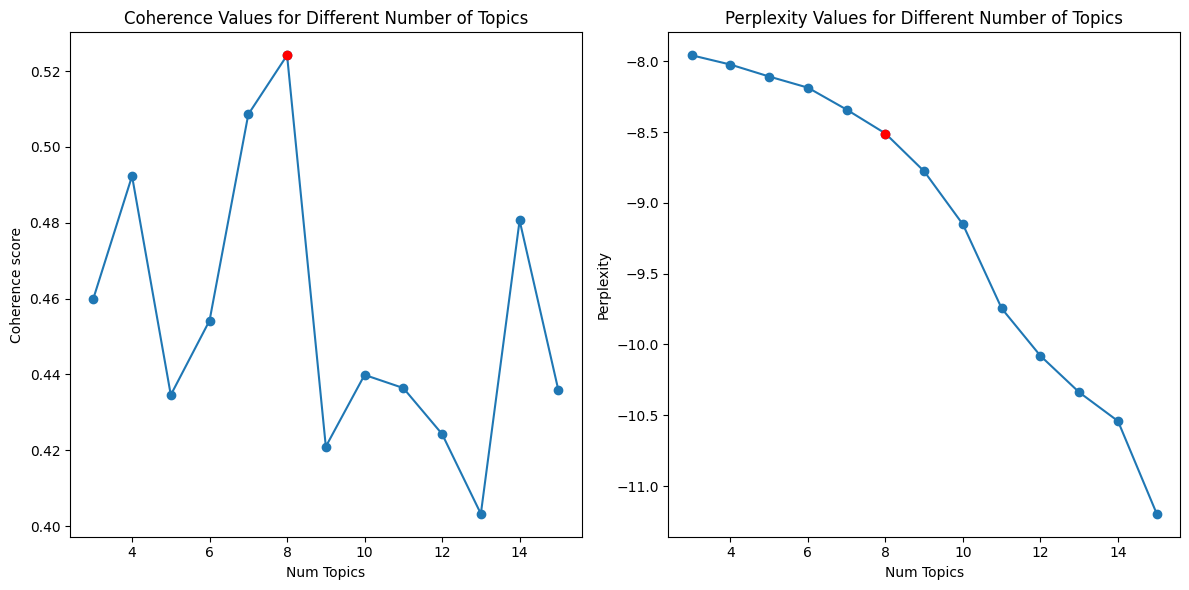

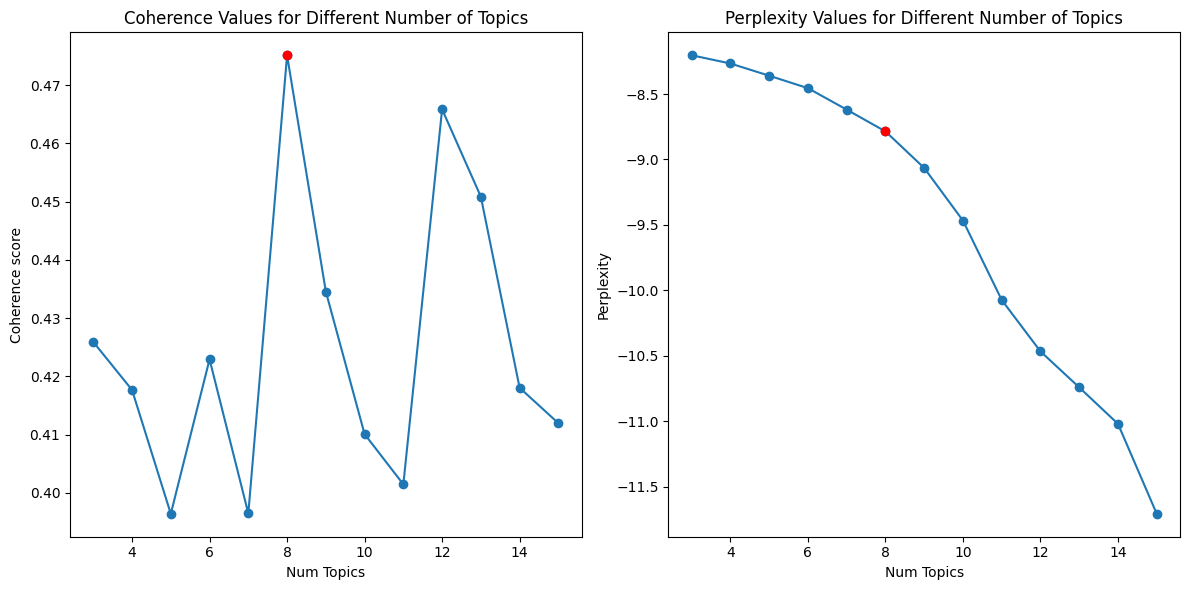

Best number of topics for 2019-2020: 8
Best number of topics for 2023-2024: 8

Better Topics for 2019-2020:
Topic 0: 0.073*"generation" + 0.035*"multilingual" + 0.032*"joint" + 0.028*"fuzzy" + 0.022*"clinical" + 0.020*"risk" + 0.020*"review" + 0.019*"area" + 0.019*"suitable" + 0.014*"final"
Topic 1: 0.031*"training" + 0.020*"datasets" + 0.020*"image" + 0.019*"dataset" + 0.018*"classification" + 0.017*"features" + 0.016*"accuracy" + 0.015*"images" + 0.013*"detection" + 0.012*"text"
Topic 2: 0.075*"visual" + 0.041*"corpus" + 0.039*"score" + 0.033*"detect" + 0.030*"event" + 0.026*"matrix" + 0.005*"turkish" + 0.005*"addition," + 0.005*"models," + 0.003*"perceptions"
Topic 3: 0.036*"agents" + 0.033*"reinforcement" + 0.027*"agent" + 0.024*"planning" + 0.023*"state" + 0.022*"policy" + 0.020*"reasoning" + 0.018*"action" + 0.018*"actions" + 0.017*"environment"
Topic 4: 0.066*"face" + 0.035*"tracking" + 0.027*"traffic" + 0.023*"scores" + 0.020*"time_series" + 0.004*"nonfrontal" + 0.003*"(e.g.," 

In [14]:

start,end = 3,16

# Perform LDA analysis on both datasets using concurrent processing
with ThreadPoolExecutor() as executor:
    future_2020 = executor.submit(lda_analysis, df_2020_processed, start, end)
    future_2023 = executor.submit(lda_analysis, df_2023_processed, start, end)

    dictionary_2020, corpus_2020, best_model_2020, best_num_topics_2020, results_2020 = future_2020.result()
    dictionary_2023, corpus_2023, best_model_2023, best_num_topics_2023, results_2023 = future_2023.result()

# Plot coherence and perplexity values
plot_values(start, end, 1, results_2020, best_num_topics_2020)
plot_values(start, end, 1, results_2023, best_num_topics_2023)

# Retrain the LDA model with better parameters for the optimal topic
optimal_num_topics = best_num_topics_2020  # Assuming the optimal number of topics is the same for both periods

# Define better parameters
better_params = {
    'num_topics': optimal_num_topics,
    'random_state': 42,
    'update_every': 1,
    'chunksize': 100,
    'passes': 20,  # Increase the number of passes
    'alpha': 'auto',
    'eta': 'auto',
    'minimum_probability': 0.01,
    'per_word_topics': True
}
# Retrain the LDA model for 2019-2020
better_model_2020 = gensim.models.LdaModel(corpus=corpus_2020, id2word=dictionary_2020, **better_params)

# Retrain the LDA model for 2023-2024
better_model_2023 = gensim.models.LdaModel(corpus=corpus_2023, id2word=dictionary_2023, **better_params)

# Print the topics for the best model
print(f"Best number of topics for 2019-2020: {best_num_topics_2020}")
print(f"Best number of topics for 2023-2024: {best_num_topics_2023}")

# Print the topics for the better model
print("\nBetter Topics for 2019-2020:")
print_topics(better_model_2020, optimal_num_topics)

print("\nBetter Topics for 2023-2024:")
print_topics(better_model_2023, optimal_num_topics)

# Calculate coherence and perplexity for the better models
coherence_model_2020 = CoherenceModel(model=better_model_2020, texts=[text.split() for text in df_2020_processed['cleaned_abstract']], dictionary=dictionary_2020, coherence='c_v')
coherence_model_2023 = CoherenceModel(model=better_model_2023, texts=[text.split() for text in df_2023_processed['cleaned_abstract']], dictionary=dictionary_2023, coherence='c_v')

better_coherence_2020 = coherence_model_2020.get_coherence()
better_perplexity_2020 = better_model_2020.log_perplexity(corpus_2020)

better_coherence_2023 = coherence_model_2023.get_coherence()
better_perplexity_2023 = better_model_2023.log_perplexity(corpus_2023)

print(f"Better Coherence for 2019-2020: {better_coherence_2020}")
print(f"Better Perplexity for 2019-2020: {better_perplexity_2020}")

print(f"Better Coherence for 2023-2024: {better_coherence_2023}")
print(f"Better Perplexity for 2023-2024: {better_perplexity_2023}")



### Further Rerun
After finding the optimal number of topics, the LDA model is ran again with this number of topics but with passes set to 20 (double than before) which means the model will run through corpus more times increasing the coherence and reducing the perplexity
## Results Analysis

Based on the graphs plotted, the red marker are the optimal number of topics based on coherence. For both the time periods, it came out to be 8 topics.
The final evaluation metrics for both the time periods:

- **Coherence for 2019-2020**: 0.5238
- **Perplexity for 2019-2020**: -8.4851
- **Coherence for 2023-2024**: 0.4829
- **Perplexity for 2023-2024**: -8.7598

The coherence scores indicate that the topics for the 2019-2020 period are slightly more interpretable compared to the 2023-2024 period. The perplexity scores suggest that the model for the 2023-2024 period has a better fit to the data, despite having slightly lower coherence.
Furthermore, the topics and their constituent keywords with weights are also shown which are better visualised in the next step

In [33]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Prepare the visualization for 2020
lda_display_2020 = gensimvis.prepare(better_model_2020, corpus=corpus_2020, dictionary=dictionary_2020, sort_topics=True)
print("LDA Visualization for 2020:")
pyLDAvis.display(lda_display_2020)

LDA Visualization for 2020:


## Result Analysis
- **Topic 1:** This is the most distinct topic; however, after analysing the most salient terms, it is not a very high quality topic and most of the terms not that meaningful on their own, but do to the size and nature of the corpus, it is difficult to remove all such terms without affecting the dataset quality
- **Topic 2 and 3:** These are the second biggest and overlapping topics both of which revolve around neural networks, training, classification and related topics which shows high quality
- **Topic 4:** This topic is for reinforcement, reasoning and agent based learning which is also a high quality topic
- **Other topics:** The rest of the topics are all formed as subsets of another slightly bigger topic. Most of the tems in these topis are very specific and do not make a 'good' topic.
> Note: I tried modelling with 4 topics only to encapsulate the subset topics into a singular topic, however, it negatively affects the other, well-formed, topics but introducing high degree of intersection signifying less topic distinction


In [39]:
# Prepare the visualization for 2023
lda_display_2023 = gensimvis.prepare(better_model_2023, corpus=corpus_2023, dictionary=dictionary_2023, sort_topics=False)
print("LDA Visualization for 2023:")
pyLDAvis.display(lda_display_2023)

LDA Visualization for 2023:


## Result Analysis
- **Topic 1:** This is quite a distinct topic and revolves around agents, search and planning related concepts
- **Topic 2:** This is also a distinct topic and focuses on keywords like evaluation, language, limitations etc signifying benchmarkin tasks and critiquing technical developments. This can be attributed to the fact that increase in LLM research led to more evaluative studies
- **Topic 3:** This topic is the biggest one, though not consisting of a lot of useful terms. Although it can be deduced based on the keywords it focuses on dataset and the actual training aspects, which can once again be attributed to training and finetuning of LLMs on difference datasets
- **Topic 4, 5, 6, 7:** These set of topics are the ones that focus on LLMs, reasoning, 'chatgpt' and represent the key development in the time period as some of the terms are non-existent in the older time period
- **Topic 8:** This topic is the the most distinct from all the other ones and focuses on primary deep learning and neural network related concepts such as attention, transformers, embeddings, tokens etc

Overall, the model is a moderately good fit for the dataset and results in a fair representation of topics


Top trending terms (2023-2024 vs 2019-2020):
Term: llms, Change: 0.2214
Term: reasoning, Change: 0.1451
Term: multimodal, Change: 0.1253
Term: visual, Change: -0.0742
Term: generation, Change: -0.0726
Term: face, Change: -0.0661
Term: large_language, Change: 0.0651
Term: llm, Change: 0.0643
Term: diffusion, Change: 0.0626
Term: labeled, Change: -0.0495
Term: procedure, Change: -0.0402
Term: corpus, Change: -0.0397
Term: score, Change: -0.0385
Term: consistency, Change: -0.0377
Term: multilingual, Change: -0.0363
Term: tracking, Change: -0.0342
Term: detect, Change: -0.0337
Term: joint, Change: -0.0315
Term: event, Change: -0.0297
Term: geometry, Change: 0.0284
Term: fuzzy, Change: -0.0281
Term: traffic, Change: -0.0269
Term: neural, Change: -0.0265
Term: matrix, Change: -0.0265
Term: alignment, Change: 0.0240


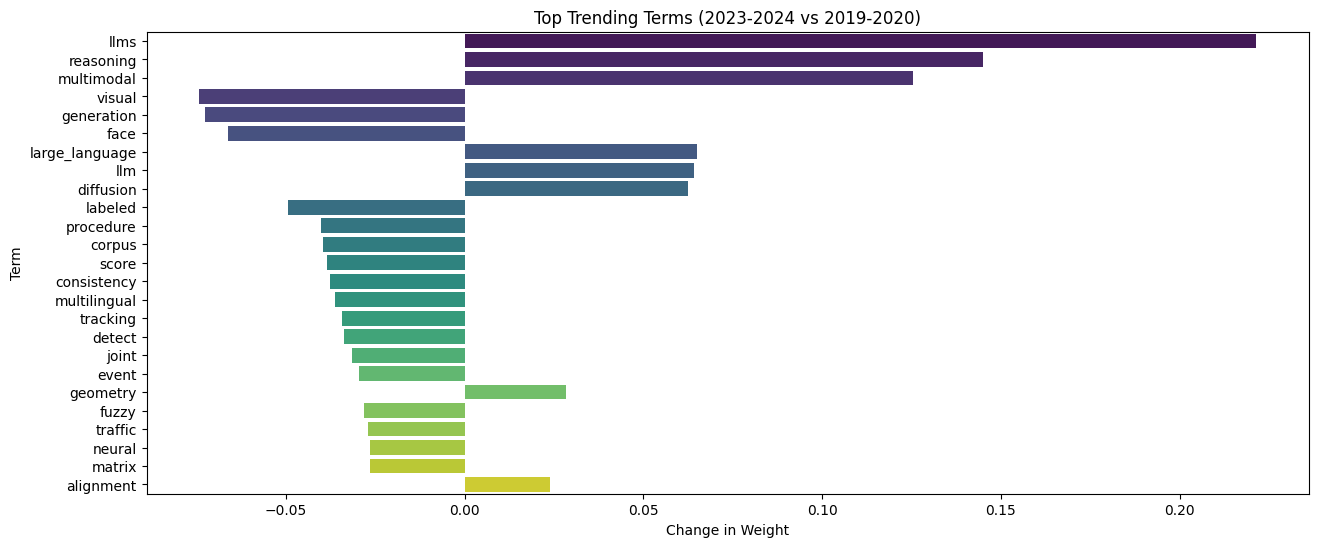

In [60]:
# Function to extract top terms from the LDA model
def extract_top_terms(lda_model, num_words=40):
    top_terms = []
    for topic_id in range(lda_model.num_topics):
        topic_terms = [(term, weight) for term, weight in lda_model.show_topic(topic_id)]
        top_terms.append(topic_terms)
    return top_terms

# Extract top terms for both time periods
top_terms_2023 = extract_top_terms(best_model_2023)
top_terms_2020 = extract_top_terms(best_model_2020)

# Function to aggregate term weights across all topics
def aggregate_term_weights(top_terms):
    term_weights = {}
    for topic in top_terms:
        for term, weight in topic:
            if term in term_weights:
                term_weights[term] += weight
            else:
                term_weights[term] = weight
    return term_weights

# Aggregate term weights for both time periods
term_weights_2023 = aggregate_term_weights(top_terms_2023)
term_weights_2020 = aggregate_term_weights(top_terms_2020)

# Function to compare term trends
def compare_term_trends(term_weights_2023, term_weights_2020):
    trends = {}
    all_terms = set(term_weights_2023.keys()).union(set(term_weights_2020.keys()))
    for term in all_terms:
        weight_2023 = term_weights_2023.get(term, 0)
        weight_2020 = term_weights_2020.get(term, 0)
        change = weight_2023 - weight_2020
        trends[term] = change
    return trends

# Perform term trend comparison
trends = compare_term_trends(term_weights_2023, term_weights_2020)

# Sort trends by absolute change
sorted_trends = sorted(trends.items(), key=lambda item: abs(item[1]), reverse=True)

num_words = 25
# Print and visualize trends
print("Top trending terms (2023-2024 vs 2019-2020):")
for term, change in sorted_trends[:num_words]:
    print(f"Term: {term}, Change: {change:.4f}")

# Visualize the comparison with a bar plot
terms = [term for term, _ in sorted_trends[:num_words]]
changes_values = [change for _, change in sorted_trends[:num_words]]

plt.figure(figsize=(15, 6))
sns.barplot(x=changes_values, y=terms, hue=terms, palette="viridis", dodge=False)

plt.title("Top Trending Terms (2023-2024 vs 2019-2020)")
plt.xlabel("Change in Weight")
plt.ylabel("Term")
plt.show()


## Result Analysis
The chart above shows the top words for each period with their weight. Negative values represent terms from 2019-2020 and vice versa. It can be clearly seen that new keyowrds like LLM, diffusion and multimodal have emerged while terms like tracking, detect and other traditional deep learning terms have reduced

## Conclusion

This project aimed to analyze and compare research papers from the ArXiv repository for the periods 2019-2020 and 2023-2024. The workflow involved several key steps:

1. **Data Collection**: Research papers were fetched from ArXiv based on specified categories and time periods, resulting in two datasets.
2. **Data Visualization**: The distribution of categories and the number of papers published over time were visualized, showing trends and shifts in research focus.
3. **Text Processing**: Techniques such as stemming, lemmatization, and phrase extraction were applied to clean the abstracts, reducing noise and improving data quality.
4. **Clustering**: KMeans clustering was used to group similar papers, and the optimal number of clusters was determined using **distortion** and **silhouette scores**.
    - **Dimensionality Reduction**: t-SNE was employed to visualize the clusters in a two-dimensional space, revealing the relationships between different research topics.
5. **Topic Modeling**: LDA topic modeling identified key topics in the research papers, with **coherence** and **perplexity** metrics guiding the selection of the optimal number of topics.
6. **Comparison**: The topics between the two time periods were compared, highlighting shifts in research focus and emerging trends.

The analysis revealed significant trends and shifts in AI research, with a move from foundational concepts to more advanced and specialized topics. 
Overall, this project provided a comprehensive analysis of research trends in AI, showcasing the evolving nature of the field and the importance of continuous monitoring and analysis of research outputs.